<a href="https://colab.research.google.com/github/giyuntf2/1day1commit/blob/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/VGG16/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
batch_size = 100
learning_rate = 1e-3
num_epoch = 20

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

X_train = datasets.CIFAR10(root='/data', train=True, download=True, transform=transform)
y_train = datasets.CIFAR10(root='/data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [3]:
train_loader = DataLoader(X_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(y_train, batch_size=64, shuffle=True, num_workers=2)

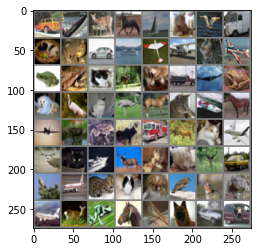

car   ship  deer  horse ship  cat   bird  truck dog   frog  car   ship  plane plane cat   plane frog  frog  cat   deer  cat   truck plane frog  dog   bird  cat   bird  horse cat   ship  horse plane deer  frog  deer  truck deer  cat   plane deer  cat   ship  deer  cat   cat   deer  car   bird  plane cat   dog   dog   bird  bird  frog  plane deer  frog  horse bird  dog   car   car  


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

# definition.

In [34]:
def conv_layer_2(in_channels, out_channels):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2)
    )

    return model

def conv_layer_3(in_channels, out_channels):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2)
    )

    return model

In [38]:
class VGG16(nn.Module):
    def __init__(self, out_channels, num_classes=10):
        super(VGG16, self).__init__()

        self.vgg16 = nn.Sequential(
            conv_layer_2(3, out_channels), #3, 64
            conv_layer_2(out_channels, out_channels*2), #128
            conv_layer_3(out_channels*2, out_channels*4), #256
            conv_layer_3(out_channels*4, out_channels*8), #512
            conv_layer_3(out_channels*8, out_channels*8) #512
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(8*out_channels*1*1, 4096),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        x = self.vgg16(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)

        return x

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_vgg16_ = VGG16(out_channels=64).to(device)


criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model_vgg16_.parameters(),lr=0.0001)

In [40]:
from torchsummary import summary as summary_

summary_(model_vgg16_, input_size=(3,32,32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
         LeakyReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
         LeakyReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
         LeakyReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
        LeakyReLU-14            [-1, 25

In [41]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model_vgg16_(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if(loss.item() > 1000):
            print(loss.item())
            for param in model_vgg16_.parameters():
                print(param.data)

        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model_vgg16_(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[1,    50] loss: 2.307
[1,   100] loss: 2.306
[1,   150] loss: 2.306
[1,   200] loss: 2.303
[1,   250] loss: 2.174
[1,   300] loss: 2.100
[1,   350] loss: 1.998
[1,   400] loss: 1.917
[1,   450] loss: 1.901
[1,   500] loss: 1.882
[1,   550] loss: 1.948
[1,   600] loss: 1.847
[1,   650] loss: 1.843
[1,   700] loss: 1.840
[1,   750] loss: 1.785
[2,    50] loss: 1.772
[2,   100] loss: 1.736
[2,   150] loss: 1.701
[2,   200] loss: 1.642
[2,   250] loss: 1.642
[2,   300] loss: 1.593
[2,   350] loss: 1.575
[2,   400] loss: 1.540
[2,   450] loss: 1.517
[2,   500] loss: 1.516
[2,   550] loss: 1.525
[2,   600] loss: 1.467
[2,   650] loss: 1.446
[2,   700] loss: 1.451
[2,   750] loss: 1.436
[3,    50] loss: 1.330
[3,   100] loss: 1.401
[3,   150] loss: 1.367
[3,   200] loss: 1.377
[3,   250] loss: 1.276
[3,   300] loss: 1.302
[3,   350] loss: 1.293
[3,   400] loss: 1.206
[3,   450] loss: 1.247
[3,   500] loss: 1.230
[3,   550] loss: 1.214
[3,   600] loss: 1.260
[3,   650] loss: 1.196
[3,   700] 

In [42]:
correct = 0
total = 0

model_vgg16_.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model_vgg16_.forward(x)
        _,output_index = torch.max(output,1)

        
        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 78.16999816894531%


# 쌩으로 구현

In [ ]:
class VGG16_(nn.Module):
    def __init__(self, out_channels, num_classes=10):
        super().__init__()

        self.layer1 = nn.Sequential(
            #layer1
            nn.Conv2d(3, out_channels, kernel_size=3, padding=1), #64
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), #64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #layer2
            nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1), #128
            nn.ReLU(),
            nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #layer3
            nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1), #256
            nn.ReLU(),
            nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #layer4
            nn.Conv2d(out_channels*4, out_channels*8, kernel_size=3, padding=1), #512
            nn.ReLU(),
            nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #layer5
            nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*out_channels*1*1, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, num_classes)
            )
        

    def forward(self, x):
        x = self.layer1(x)

        x = x.view(x.size(0), -1)

        x = self.fc_layer(x)

        return x

In [ ]:
from torchsummary import summary as summary_

summary_(model_vgg16, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_vgg16 = VGG16_(out_channels=64).to(device)

optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()